In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
from hera_cal import redcal
import cPickle as cp
import h5py
import linsolve

## Sample Covariance matrix

The sample covariance matrix for a $p \times 1$ random vector given $n$ independent observations is given by:

$$Q = \frac{1}{n-1} \Sigma (x_i - \bar{x})(x_i - \bar{x})^T $$

**Properties**:
1. For a gaussian random distribution, the variance is $2\sigma^2$ if the random numbers were drawn with scale$=\sigma$.

2. The sample covariance matrix will *not* have zero off-diagonal terms even though the terms have been drawn independently are not covariant.

3. The off-diagonal terms seem to be proportional to the variance of the variables.

In [120]:
def noise(loc=0,scale=1,size=1):
    return np.random.normal(loc=loc,scale=scale,size=size) + 1j*np.random.normal(loc=loc,scale=scale,size=size)

<IPython.core.display.Javascript object>


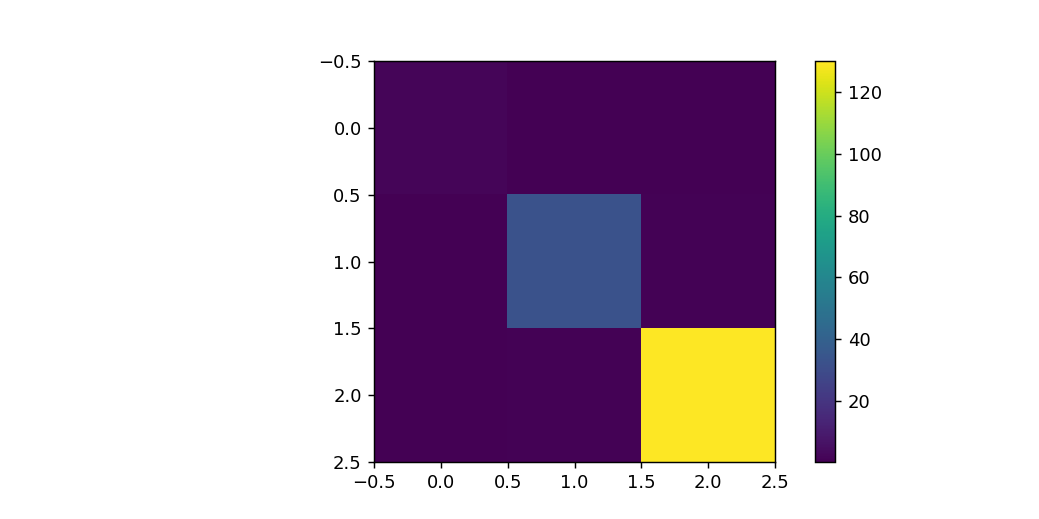

In [121]:
data = np.vstack((noise(scale=1,size=1000),noise(scale=4,size=1000)))
data = np.vstack((data,noise(scale=8,size=1000)))
cov = np.cov(data)

plt.figure(figsize=(8,4))
plt.imshow(np.abs(cov))
plt.colorbar()

# Covariance matrix for Ax=b

For the system of equations represented by $Ax=b$, the covariance matrix is given by the neat formula:

$$Q = (A^TN^{-1}A)^{-1}$$

When the errors are independent (as in our case), the noise covariance matrix drops out and we get:

$$Q = \sigma^2(A^TA)^{-1}$$

In the limit of a large number of solutions for the estimate $\hat{x}$, the sample covariance matrix should equal the above matrix.

$$\Sigma (x_i-\bar{x})(x_i-\bar{x})^T \rightarrow \sigma^2 (A^TA)^{-1}$$

# Logarithmic solution for products

When you have a system of equations involving purely the products of variables, you can solve them by linearlizing with logarithms.

$$xy = 3  \rightarrow \log{x} + \log{y} = \log{3} $$

This becomes more interesting when the variables are complex numbers. The logarithm of a complex number separates the amplitude and phase into the real and imaginary parts when you linearize.

$$x = a + ib = |x|e^{i\phi} = e^{\eta} e^{i\phi} = e^{\eta+i\phi}$$
$$\log{e^{\eta + i\phi}} = \eta + i\phi = \log{|x|} + i\angle{x}$$

So when you are linearizing a system of complex equations, you are naturally solving **two independent systems** of equations- one for the **real or amplitude part** and the other for the **imaginary or phase part** of the variable.

# Example

$$xy = 4i $$
$$xz^* = 6 $$
$$y^*z = 12$$

True solution:

$$x = 1+1j$$
$$y = 2+2j$$
$$z = 3+3j$$

<IPython.core.display.Javascript object>


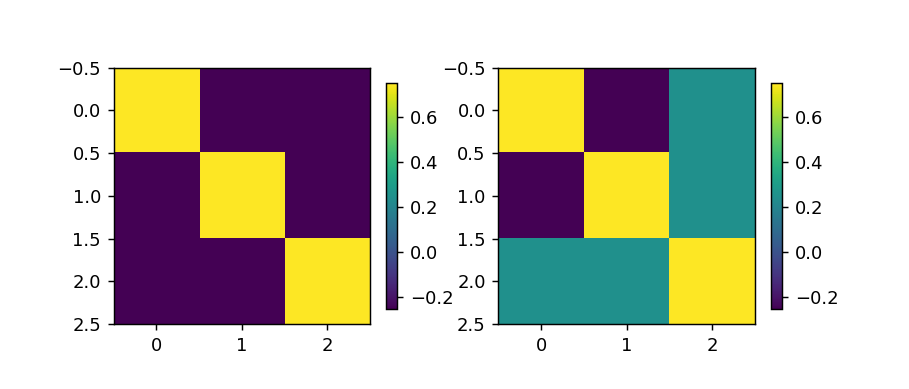

In [36]:
Ar = [[1, 1, 0], [1, 0, 1], [0, 1, 1]]
Ai = [[1, 1, 0], [1, 0, -1], [0, -1, 1]]
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(np.linalg.inv(np.dot(np.transpose(Ar),Ar)))
plt.colorbar(shrink=0.75)
plt.subplot(122)
plt.imshow(np.linalg.inv(np.dot(np.transpose(Ai),Ai)))
plt.colorbar(shrink=0.75)

In [26]:
lps = linsolve.LogProductSolver(data)
sol = lps.solve()
for k,v in sol.items():
    print k, np.log(v)

y (1.0397208+0.7853982j)
x (0.3465736+0.7853982j)
z (1.4451858+0.7853982j)


In [122]:
data = {}
data['x*y'] = 4j
data['x*z_'] = 6
data['y_*z'] = 12

X = np.zeros([3,1])

Nsim = 2**10
for i in range(Nsim):
    data_sim = {k:100*noise() for k,v in data.items()}
    lps = linsolve.LogProductSolver(data_sim)
    sol = lps.solve()
    X = np.hstack((X,[sol['x'],sol['y'],sol['z']]))
X = X[:,1:]

<IPython.core.display.Javascript object>


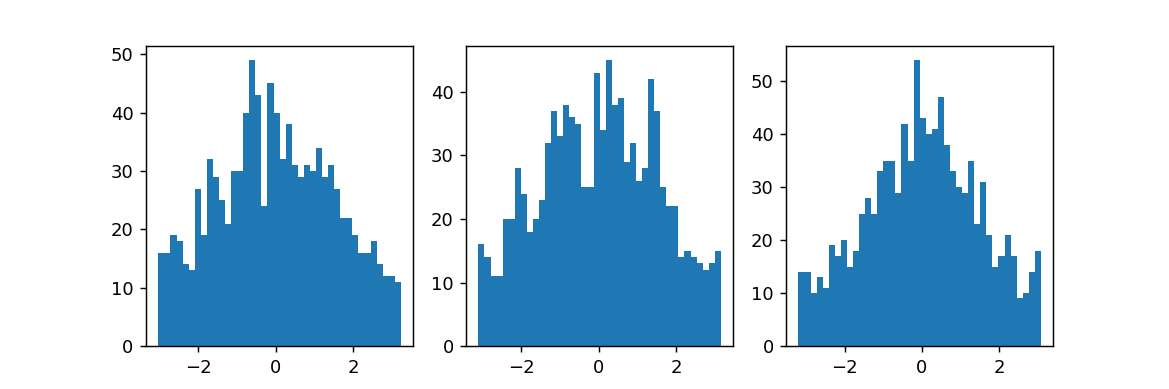

In [117]:
plt.figure(figsize=(9,3))
x_avg = np.mean(np.log(X),axis=1)
plt.subplot(131)
freq = plt.hist(np.imag(np.log(X[0]))-np.imag(x_avg[0]),bins=40)
plt.subplot(132)
freq = plt.hist(np.imag(np.log(X[1]))-np.imag(x_avg[1]),bins=40)
plt.subplot(133)
freq = plt.hist(np.imag(np.log(X[2]))-np.imag(x_avg[2]),bins=40)

In [123]:
np.std(np.real(np.log(X)),axis=1)**2

array([0.31569786, 0.32608069, 0.32722174])

In [125]:
1/(2*np.sqrt(2))

0.35355339059327373

<IPython.core.display.Javascript object>


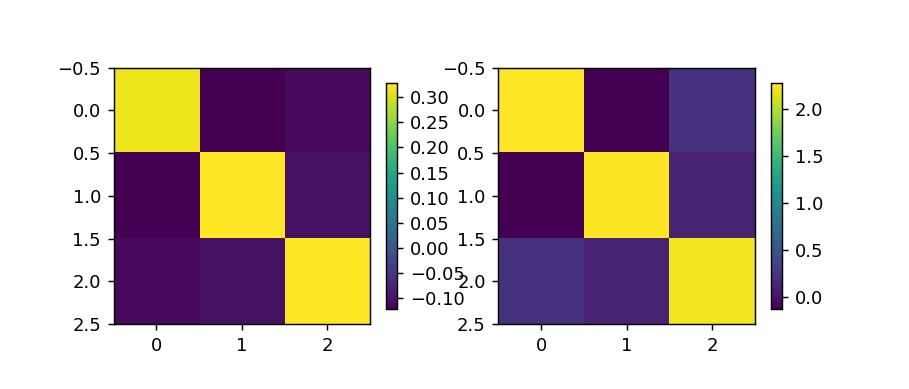

In [126]:
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(np.cov(np.real(np.log(X))))
plt.colorbar(shrink=0.75)
plt.subplot(122)
plt.imshow(np.cov(np.imag(np.log(X))))
plt.colorbar(shrink=0.75)

# Constant gains

In [73]:
fqs = .150
lsts = np.pi/4

In [74]:
ants = np.loadtxt('antenna_positions_37.dat')
antpos = {k:v for k,v in zip(range(37),ants)}
reds = redcal.get_reds(antpos)

In [106]:
gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,2**10),gain_scatter=0)
data = {k:v+10000*redcal.noise((1,2**10)) for k,v in data.items()}

redcalibrator = redcal.RedundantCalibrator(reds)
sol_degen = redcalibrator.logcal(data)
sol = redcalibrator.remove_degen(antpos, sol_degen, degen_sol=gains_input)
    
redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
subsol_degen = redcalibrator_sub.logcal(data)
subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen, degen_sol=gains_input)

<IPython.core.display.Javascript object>


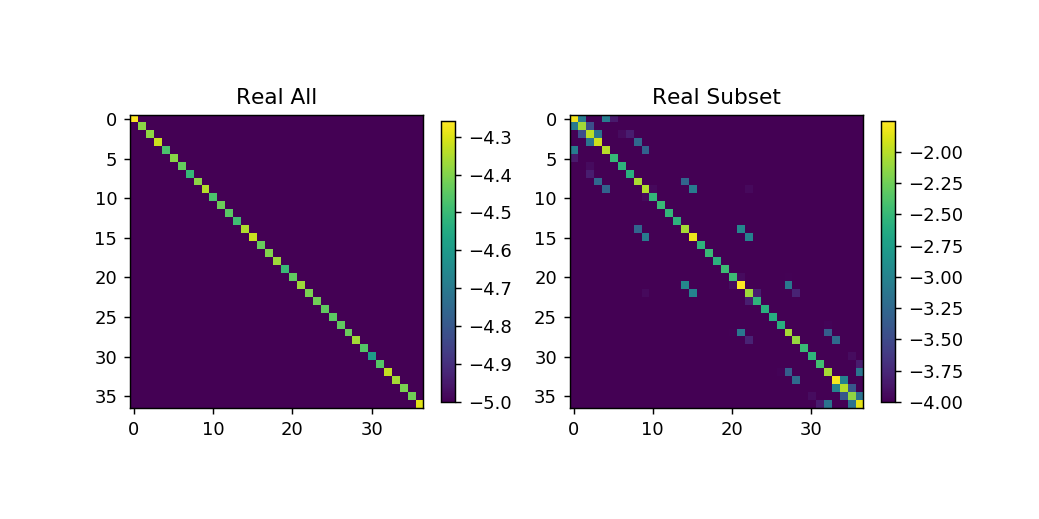

In [107]:
ant_gainres = []
ant_gainres_all = []

for ant in range(37):
    ant_gainres_all.append(np.log(sol[(ant,'x')][0]))
    ant_gainres.append(np.log(subsol[(ant,'x')][0]))

cov = np.cov(np.real(ant_gainres))
cov_all = np.cov(np.real(ant_gainres_all))

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('Real All')
plt.imshow(np.log(np.abs(cov_all)),vmin=-5)
plt.colorbar(shrink=0.7)

plt.subplot(122)
plt.title('Real Subset')
plt.imshow(np.log(np.abs(cov)),vmin=-4)
plt.colorbar(shrink=0.7)

# plt.subplot(223)
# plt.title('Imag subset')
# plt.imshow(np.imag(cov))
# plt.colorbar(shrink=0.7)

# plt.subplot(224)
# plt.title('Imag all')
# plt.imshow(np.imag(cov_all))
# plt.colorbar(shrink=0.7)

<IPython.core.display.Javascript object>


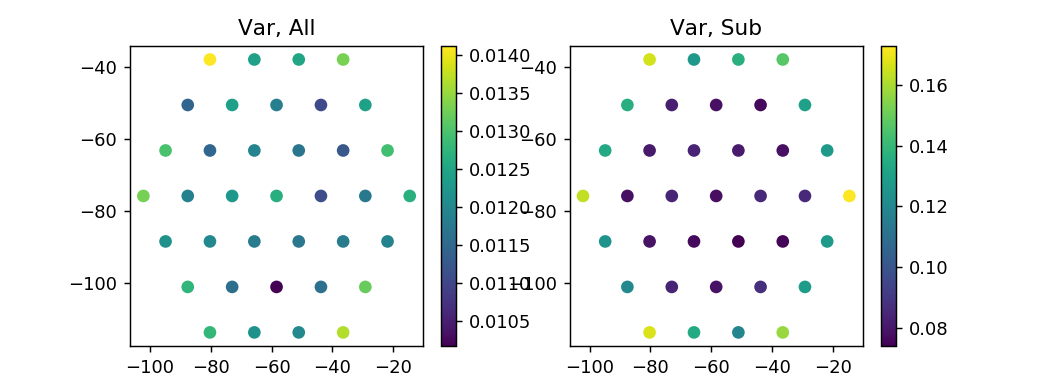

In [113]:
x = [v[0] for v in antpos.values()]
y = [v[1] for v in antpos.values()]

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.title('Var, All')
plt.scatter(x,y,c=np.diag(cov_all),cmap='viridis')
plt.colorbar()
plt.subplot(122)
plt.title('Var, Sub')
plt.scatter(x,y,c=np.diag(cov),cmap='viridis')
plt.colorbar()
plt.show()

# Add lognormal noise to data

In [ ]:
Nsim = 2**10
gains = {}
gain_subsols_log = {}
gain_allsols_log = {}
noise = {}

for a in range(37):
    gains[(a,'x')] = []
    gain_subsols_log[(a,'x')] = []
    gain_allsols_log[(a,'x')] = []
    
gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,1))
for bl in data.keys():
    noise[bl] = []
    
for i in range(Nsim):
    print i
    gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,1))
    for k,v in data.items():
        n = redcal.noise((1,1))
        data[k] = np.exp(np.log(v) + n)
        noise[k].append(data[k]-v)
    
    redcalibrator = redcal.RedundantCalibrator(reds)
    sol_degen = redcalibrator.logcal(data)
    sol = redcalibrator.remove_degen(antpos, sol_degen, degen_sol=gains_input)
    
    redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
    subsol_degen = redcalibrator_sub.logcal(data)
    subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen, degen_sol=gains_input)
    
    for a in range(37):
        gains[(a,'x')].append(gains_input[(a,'x')][0][0])
        gain_subsols[(a,'x')].append(subsol[(a,'x')][0][0])
        gain_allsols[(a,'x')].append(sol[(a,'x')][0][0])
        
# Convert to numpy array from list for easy indexing
for a in range(37):
    gains[(a,'x')] = np.asarray(gains[(a,'x')])
    gain_subsols[(a,'x')] = np.asarray(gain_subsols[(a,'x')])
    gain_allsols[(a,'x')] = np.asarray(gain_allsols[(a,'x')])

In [ ]:
noise_allbls = []
for bl in noise.keys():
    noise_allbls.append(np.array(noise[bl])[:,0,0])
    
ncov = np.cov(noise_allbls)

plt.figure()
plt.imshow(np.real(ncov), interpolation='nearest')
plt.colorbar(shrink=0.75)

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(121)
hist, bins, misc = plt.hist(np.diag(np.real(noise_allbls)),bins=100)
plt.subplot(122)
hist, bins, misc = plt.hist(np.diag(np.imag(noise_allbls)),bins=100)

In [ ]:
Nsim = 2**10
gains = {}
gain_subsols = {}
gain_allsols = {}

for a in range(37):
    gains[(a,'x')] = []
    gain_subsols[(a,'x')] = []
    gain_allsols[(a,'x')] = []
    
for i in range(Nsim):
    print i
    gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,1))
    for k,v in data.items():
        n = redcal.noise((1,1))
        data[k] = v+ 2*n
    
    redcalibrator = redcal.RedundantCalibrator(reds)
    sol_degen = redcalibrator.logcal(data)
    sol = redcalibrator.remove_degen(antpos, sol_degen, degen_sol=gains_input)
    
    redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
    subsol_degen = redcalibrator_sub.logcal(data)
    subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen, degen_sol=gains_input)
    
    for a in range(37):
        gains[(a,'x')].append(gains_input[(a,'x')][0][0])
        gain_subsols[(a,'x')].append(subsol[(a,'x')][0][0])
        gain_allsols[(a,'x')].append(sol[(a,'x')][0][0])

# Convert to numpy array from list for easy indexing
for a in range(37):
    gains[(a,'x')] = np.asarray(gains[(a,'x')])
    gain_subsols[(a,'x')] = np.asarray(gain_subsols[(a,'x')])
    gain_allsols[(a,'x')] = np.asarray(gain_allsols[(a,'x')])

In [ ]:
noise_allbls = []
for bl in noise.keys():
    noise_allbls.append(np.array(noise[bl])[:,0,0])
    
ncov = np.cov(noise_allbls)

plt.figure()
plt.imshow(np.real(ncov), interpolation='nearest')
plt.colorbar(shrink=0.75)

In [ ]:
ant_gainres = []
ant_gainres_all = []
N = 1024

for ant in gains.keys():
    ant_gainres_all.append(gain_allsols[ant][:N]-np.mean(gain_allsols[ant][:N]))
    ant_gainres.append(gain_subsols[ant][:N]-np.mean(gain_subsols[ant][:N]))
    #ant_gainres_all.append(gain_allsols[ant][:N]-gains[ant][:N])
    #ant_gainres.append(gain_subsols[ant][:N]-gains[ant][:N])

# np.shape(ant_gainres)
cov = np.cov(ant_gainres)
cov_all = np.cov(ant_gainres_all)

#cov = np.dot(ant_gainres, np.conjugate(ant_gainres).T)/(np.shape(ant_gainres)[1]-1)
#cov_all = np.dot(ant_gainres_all,np.conjugate(ant_gainres_all).T)/(np.shape(ant_gainres_all)[1]-1)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.real(cov))
plt.colorbar(shrink=0.7)

plt.subplot(222)
plt.imshow(np.real(cov_all))
plt.colorbar(shrink=0.7)

plt.subplot(223)
plt.imshow(np.imag(cov))
plt.colorbar(shrink=0.7)

plt.subplot(224)
plt.imshow(np.imag(cov_all))
plt.colorbar(shrink=0.7)

# plt.matshow(np.log10(np.abs(cov)))
# plt.colorbar(shrink=0.7)

# plt.matshow(np.log10(np.abs(cov_all)))
# plt.colorbar(shrink=0.7)

In [ ]:
plt.figure()
plt.plot(np.real((np.array(noise[(0,14,'xx')])[:,0,0])))

In [ ]:
for a in range(37):
    gains[(a,'x')] = np.asarray(gains[(a,'x')])
    gain_subsols[(a,'x')] = np.asarray(gain_subsols[(a,'x')])
    gain_allsols[(a,'x')] = np.asarray(gain_allsols[(a,'x')])

In [ ]:
2**24

In [ ]:
gains[(24,'x')]

In [ ]:
gain_subsols[(24,'x')]

In [ ]:
plt.figure()
plt.semilogy(np.abs(gain_allsols[(24,'x')]-gains[(24,'x')]))

In [ ]:
# redcalibrator = redcal.RedundantCalibrator(reds)
# sol_degen = redcalibrator.logcal(data)
# sol = redcalibrator.remove_degen(antpos, sol_degen, degen_sol=gains)

In [ ]:
# redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
# subsol_degen = redcalibrator_sub.logcal(data)
# subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen, degen_sol=gains)

In [ ]:
# with open('allbases_sols_1.cp','r') as fp:
#     sol = cp.load(fp)

In [ ]:
# with open('subset_sols_1.cp','r') as fp:
#     subsol = cp.load(fp)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for ant in range(0,37):
    fig.suptitle('Ant %d'%ant)
    ax.clear()
    ax.semilogy(np.abs(gains[(ant,'x')]),'c',label='All baselines',alpha=0.3)
    ax.semilogy(np.abs(gain_allsols[(ant,'x')]-gains[(ant,'x')]),'b',label='All baselines',alpha=0.7)
    ax.semilogy(np.abs(gain_subsols[(ant,'x')]-gains[(ant,'x')]),'m',label='Only shortest baselines',alpha=0.3)
    #ax.semilogy(np.abs(gains[(ant,'x')][0]),'g',label='Input gains',alpha=0.7)
#     ax.plot(np.angle(subsol[(ant,'x')][0])-np.angle(gains[(ant,'x')][0]),'m',label='Only shortest baselines',alpha=0.5)
#     ax.plot(np.angle(sol[(ant,'x')][0])-np.angle(gains[(ant,'x')][0]),'b',label='All baselines',alpha=0.7)
#     #ax.plot(np.angle(gains[(ant,'x')][0]),'g',label='Input gains',alpha=0.7)
    time.sleep(1)
    fig.canvas.draw()

In [ ]:
np.shape(gain_subsols[(23,'x')][:23])

# Construct the covariance matrix

For a specific lst, construct a matrix of residuals of the antenna gains. 

$$R = N_{ants} \times N_{fqs}$$

Construct the covariance matrix from this by computing $RR^{\dagger}$

In [ ]:
gain_allsols[(23,'x')]

In [ ]:
100/np.sqrt(2)

In [ ]:
#ant = (23,'x')
ant = 23

plt.figure()

for i in range(1024,65536,1024):
    plt.plot(i,np.abs(np.mean(ant_gainres_v2[ant][:i])),'ko')

In [ ]:
2**20

In [ ]:
ant_gainres_v2 = []
ant_gainres_all_v2 = []
N = 65536
for ant in gains.keys():
    #ant_gainres_all.append(gain_allsols[ant][:N]-np.mean(gain_allsols[ant][:N]))
    #ant_gainres.append(gain_subsols[ant][:N]-np.mean(gain_subsols[ant][:N]))
    ant_gainres_all_v2.append(gain_allsols[ant][:N]-gains[ant][:N])
    ant_gainres_v2.append(gain_subsols[ant][:N]-gains[ant][:N])

# np.shape(ant_gainres)
cov_v2 = np.cov(ant_gainres)
cov_all_v2 = np.cov(ant_gainres_all)

# cov_v2 = np.dot(ant_gainres_v2, np.conjugate(ant_gainres_v2).T)/(np.shape(ant_gainres_v2)[1])
# cov_all_v2 = np.dot(ant_gainres_all_v2,np.conjugate(ant_gainres_all_v2).T)/(np.shape(ant_gainres_all_v2)[1])

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.abs(np.real(cov_v2)))
plt.colorbar(shrink=0.7)

plt.subplot(222)
plt.imshow(np.abs(np.real(cov_all_v2)))
plt.colorbar(shrink=0.7)

plt.subplot(223)
plt.imshow(np.imag(cov_v2))
plt.colorbar(shrink=0.7)

plt.subplot(224)
plt.imshow(np.imag(cov_all_v2))
plt.colorbar(shrink=0.7)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.real(cov),interpolation='nearest')
plt.colorbar(shrink=0.75)
plt.subplot(122)
plt.imshow(np.real(cov_v2),interpolation='nearest')
plt.colorbar(shrink=0.75)

In [ ]:
# 1. Many more instances
# 2. Change gains

In [ ]:
np.shape(ant_gainres)

In [ ]:
ant_gainres = []
ant_gainres_all = []
for ant in gains.keys():
    ant_gainres_all.append(np.mean(sol[ant],axis=0)-gains[ant][lst])
    ant_gainres.append(np.mean(subsol[ant],axis=0)-gains[ant][lst])

cov = np.dot(np.real(np.matrix(ant_gainres)),np.real(np.matrix(np.conjugate(ant_gainres)).T))
cov_all = np.dot(np.real(np.matrix(ant_gainres_all)),np.real(np.matrix(np.conjugate(ant_gainres_all))).T)

plt.matshow(cov)
plt.colorbar(shrink=0.7)

plt.matshow(cov_all)
plt.colorbar(shrink=0.7)

In [ ]:
# gains = {}; vis = {}; hdr = {}

# with h5py.File('fake_vis.hdf5','r') as fp:
#     for key in fp.keys():
#         if (key.rfind('-') > 0):
#             a1, a2 = key.split('-')
#             vis[(int(a1),int(a2),'xx')] = fp[key][...]
#         elif (key.startswith('g')):
#             k = key.lstrip('g')
#             gains[(int(k),'x')] = np.repeat([fp[key][...]],10,axis=0)
#         else: hdr[key] = fp[key][...]

In [ ]:
# mdlvis = {}
# for ant1,ant2,pol in vis.keys():
#     mdlvis[(ant1,ant2,pol)] = vis[(ant1,ant2,pol)]/(gains[(ant1,'x')] * gains[(ant2,'x')].conj())

## Single simulation

In [5]:
gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,1))
data = {k:v+0*redcal.noise((1,1)) for k,v in data.items()}

redcalibrator = redcal.RedundantCalibrator(reds)
sol_degen = redcalibrator.logcal(data)
sol = redcalibrator.remove_degen(antpos, sol_degen, degen_sol=gains_input)
    
redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
subsol_degen = redcalibrator_sub.logcal(data)
subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen, degen_sol=gains_input)

In [8]:
ant_gainres = []
ant_gainres_all = []

for ant in range(37):
    ant_gainres_all.append((sol[(ant,'x')][0]))
    ant_gainres.append((subsol[(ant,'x')][0]))

<IPython.core.display.Javascript object>


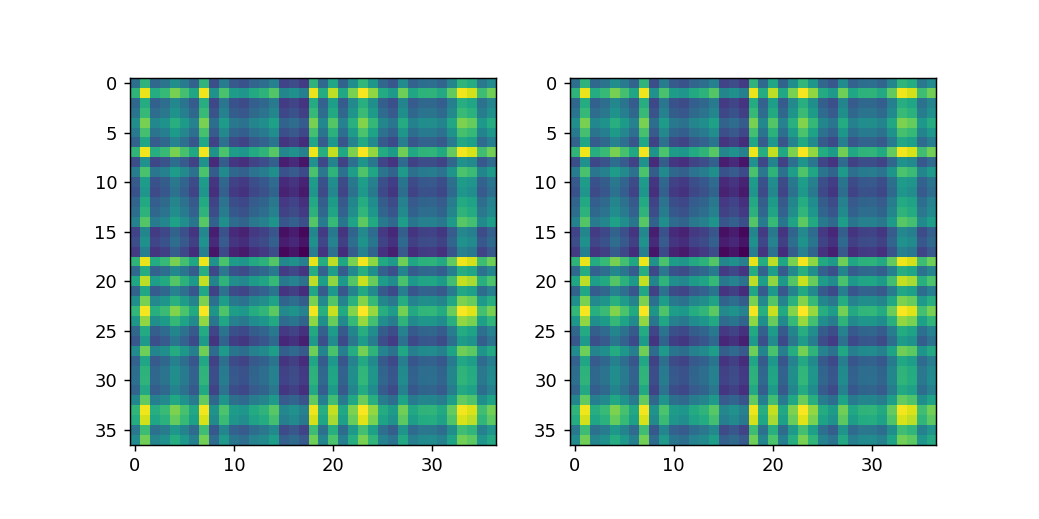

In [9]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(np.dot(np.abs(ant_gainres),np.transpose(np.abs(ant_gainres))))
plt.subplot(122)
plt.imshow(np.dot(np.abs(ant_gainres_all),np.transpose(np.abs(ant_gainres_all))))